# Section I

**Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pyLDAvis
from pyLDAvis import gensim_models
from IPython.core.display import display, HTML
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk.corpus
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.tokenize import word_tokenize #Stemming
import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
from textblob import TextBlob, Word #Lammitizer
import warnings
warnings.simplefilter('ignore')
from wordcloud import WordCloud
import plotly.express as px
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.corpora as corpora
from nltk.util import ngrams
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.decomposition import LatentDirichletAllocation
import spacy
import spacy.cli
#spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")

#Model Building for Text Classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

**Load Data Set**

In [2]:
df = pd.read_csv("articles1.csv")
df1 = pd.read_csv("articles2.csv")
df2 = pd.read_csv("articles3.csv")
frames = [df, df1, df2]
df_r = pd.concat(frames)
df_r.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [3]:
df["title"].head()

0    House Republicans Fret About Winning Their Hea...
1    Rift Between Officers and Residents as Killing...
2    Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...
3    Among Deaths in 2016, a Heavy Toll in Pop Musi...
4    Kim Jong-un Says North Korea Is Preparing to T...
Name: title, dtype: object

In [4]:
df["content"].head()

0    WASHINGTON  —   Congressional Republicans have...
1    After the bullet shells get counted, the blood...
2    When Walt Disney’s “Bambi” opened in 1942, cri...
3    Death may be the great equalizer, but it isn’t...
4    SEOUL, South Korea  —   North Korea’s leader, ...
Name: content, dtype: object

**Exploratory Data Analysis**

In [5]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142570 entries, 0 to 42570
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   142570 non-null  int64  
 1   id           142570 non-null  int64  
 2   title        142568 non-null  object 
 3   publication  142570 non-null  object 
 4   author       126694 non-null  object 
 5   date         139929 non-null  object 
 6   year         139929 non-null  float64
 7   month        139929 non-null  float64
 8   url          85559 non-null   object 
 9   content      142570 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 12.0+ MB


In [6]:
df_r.shape

(142570, 10)

In [7]:
df_r.isnull().sum()

Unnamed: 0         0
id                 0
title              2
publication        0
author         15876
date            2641
year            2641
month           2641
url            57011
content            0
dtype: int64

In [8]:
df_r.drop(["Unnamed: 0","author","date","year","month","id","url","publication"],inplace=True,axis=1)
df_null = df_r[df_r.title.isna()]
for cont in df_null["content"]:
    print(len(cont))
df_r.dropna(inplace=True)
df_r.shape

253
2517


(142568, 2)

# Section II

# **Data Pre-processing**

**Data Cleaning, Tokenization, BiGram, TriGram and lemmatization on title field**

In [10]:
def data_preprcessing_title(text_title):
    
    #Lower case all texts
    text_title = text_title.lower() 
    
    #remove unicodes
    text_title = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text_title) 
    
    #remove stop words
    stop = stopwords.words('english')
    
    #Most repeatative words also need to remove as these are biasing the topics, found these from topic modeling words
    extended_stopwords = ['trump', 'said', 'clinton','campaign','hillary','donald','take','make','would',
                          'say', 'could', 'be','like','time','year','people','know', 'good', 'get', 'do', 'done', 
                          'try', 'many', 'some', 'nice', 'thank', 'think', 'see','rather', 'easy', 'easily', 'lot',
                          'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right','line', 'also',
                          'may', 'come']
    text_title1 = " ".join(word for word in text_title.split() if word not in (stop))
    text_title = " ".join(word for word in text_title1.split() if word not in (extended_stopwords))
  
    #remove digits
    text_title = ''.join((xt for xt in text_title if not xt.isdigit()))
    
    #remove short words < len 2
    text_title = ' '.join(wd for wd in text_title.split() if len(wd)>3)
    
    #remove salutaions
    salutation = ['miss','mr','ms','mrs']
    text_title = " ".join(wrd for wrd in text_title.split() if wrd not in (salutation))

    return text_title

#Convert texts to tokens
def tokenize(text_title):
    for ln in text_title:
        ln = gensim.utils.simple_preprocess(str(ln), deacc=True) #simple_preprocess() Convert text into a list of tokens    
        yield(ln) 
        
#Lemmatize the tags
def lemmatize(text_title,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_title = [bigram_model[doc] for doc in text_title]
    text_title = [trigram_model[bigram_model[doc]] for doc in text_title]
    clean_txt = []
    nlp = spacy.load('en_core_web_md', disable=['parser','ner']) #'en_core_web_md' based on text size)
    for lne in text_title:
        dc = nlp(" ".join(lne)) 
        clean_txt.append([token.lemma_ for token in dc if token.pos_ in allowed_postags])         
    return clean_txt

#Remove stop words after lemmatization as sometimes post lemmatization it creates some stop words
stop = stopwords.words('english')
extended_stopwords = ['s','say','take','make','would', 'say', 'could', 'be','like','time','year','people','know',
                      'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see','rather', 
                      'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right','line',
                      'even', 'also', 'may', 'take', 'come','miss','mr','ms','mrs','trump', 'said', 'clinton','campaign',
                      'hillary','donald']
def remove_stop_words(sentence):
    for txt in sentence:
        clean_sentence=([wrd for wrd in txt if wrd.lower() not in stop])
        clean_sentence=([wrd for wrd in txt if wrd.lower() not in extended_stopwords])
        yield(clean_sentence)

#Function calling
convert = lambda x: '%.0f' % x if isinstance(x,float) else x #presence of floating numbers, so removing these also
df_r['title'] = df_r['title'].apply(convert)
df_r['title'] = df_r['title'].apply(data_preprcessing_title) 
print("Cleaning is done")

d_list = df_r["title"].values.tolist()
word_lists = list(tokenize(d_list))
print("Tokenization on title is done")

#Building Bigram and Trigram models
bigram = gensim.models.Phrases(word_lists, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[word_lists], threshold=100)  
bigram_model = gensim.models.phrases.Phraser(bigram) #building the model now
trigram_model = gensim.models.phrases.Phraser(trigram)
clean_df= lemmatize(word_lists)  # processed Text Data!
print("Lemmatization on title is done")
clean_df= list(remove_stop_words(clean_df))
print("Stop word removal after lemmatization is also done")
print("Preprocessing is completed for title field")

Cleaning is done
Tokenization on title is done
Lemmatization on title is done
Stop word removal after lemmatization is also done
Preprocessing is completed for title field


**For content we have a separate data processing code because we are not removing any repeatative extended words due to no demand of it**

In [11]:
def data_preprcessing_content(text_content):
    
    #Lower case the letters
    text_content = text_content.lower()
    
    #remove unicodes
    text_content = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text_content)
    
    #remove stop words
    stop = stopwords.words('english')
    text_content = " ".join(wrd for wrd in text_content.split() if wrd not in (stop))
  
    #remove digits
    text_content = ''.join((xt for xt in text_content if not xt.isdigit()))
    
    #remove short words
    text_content = ' '.join(wrd for wrd in text_content.split() if len(wrd)>3)
    
    #remove salutaions
    salutation = ['miss','mr','ms','mrs']
    text_content = " ".join(wrd for wrd in text_content.split() if wrd not in (salutation))

    return text_content

#convert the POS tags to the WordNet
def postag(text_content):
    if text_content.startswith('J'):
        return wordnet.ADJ
    elif text_content.startswith('V'):
        return wordnet.VERB
    elif text_content.startswith('N'):
        return wordnet.NOUN
    elif text_content.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # it will keep noun as bydefault

# Define a function to lemmatize a sentence
def lemmatize_sentence(text_content):
    tokenized_sent = nltk.word_tokenize(text_content)
    tagged_sent = nltk.pos_tag(tokenized_sent)
    lemmatized_sent = [lemmatizer.lemmatize(wrd, postag(pos)) for wrd, pos in tagged_sent]
    return ' '.join(lemmatized_sent)

#Remove stopwords after lemmatization
def remove_stopword(text_content):
    stop = stopwords.words('english')
    text_content = " ".join(wrd for wrd in text_content.split() if wrd not in (stop))
    return text_content

#Function calling
df_r['content'] = df_r['content'].apply(data_preprcessing_content)
print("Cleaning is completed")
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
df_r['content'] = df_r['content'].apply(lemmatize_sentence)
print("Tokenization and Lemmatization is completed")
df_r['content'] = df_r['content'].apply(remove_stopword)
print("Stop word removal after lemmatization is completed")
print("Pre-processing is completed for content field")

Cleaning is completed
Tokenization and Lemmatization is completed
Stop word removal after lemmatization is completed
Pre-processing is completed for content field


# Section III

# Topic Modeling

**Experiment**

**Now Build the topic model on Title column and extract the topic**

In [12]:
# Mapping between word and a integer value which represent that word
map_int = corpora.Dictionary(clean_df)

# Create Corpus
corpus = [map_int.doc2bow(text_title) for text_title in clean_df]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=map_int, passes=2, workers=2)

#Show the words of each topic along with scores
for idnx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idnx, topic))

Topic: 0 
Words: 0.029*"vote" + 0.014*"fall" + 0.013*"love" + 0.012*"leave" + 0.012*"review" + 0.012*"brexit" + 0.010*"money" + 0.009*"challenge" + 0.009*"issue" + 0.009*"food"
Topic: 1 
Words: 0.023*"first" + 0.020*"talk" + 0.016*"lose" + 0.015*"thing" + 0.015*"meet" + 0.015*"political" + 0.014*"work" + 0.012*"president" + 0.011*"test" + 0.010*"pick"
Topic: 2 
Words: 0.031*"attack" + 0.028*"police" + 0.016*"shoot" + 0.014*"kill" + 0.014*"look" + 0.013*"report" + 0.012*"break" + 0.012*"source" + 0.012*"arrest" + 0.012*"dead"
Topic: 3 
Words: 0.034*"woman" + 0.026*"show" + 0.026*"explain" + 0.014*"government" + 0.010*"photo" + 0.010*"well" + 0.010*"rally" + 0.009*"head" + 0.009*"sign" + 0.009*"video"
Topic: 4 
Words: 0.017*"become" + 0.015*"high" + 0.012*"move" + 0.011*"trade" + 0.011*"deal" + 0.010*"fight" + 0.010*"health" + 0.010*"plan" + 0.009*"share" + 0.008*"stand"
Topic: 5 
Words: 0.023*"back" + 0.021*"still" + 0.016*"watch" + 0.010*"speech" + 0.010*"last" + 0.010*"close" + 0.010*

**Assign the dominant topic to each associated text of the dataframe
based on probability score contribution**

In [15]:
def dominant_topic(ldamodel=None, corpus=corpus, texts=d_list):
    topics_df = pd.DataFrame()

    # Get main topic in each document based on word contribtion scoring
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True) #print individual raws
        # Get the Dominant topic and Keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),
                                             ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'contribution_score', 'Topic_Word_List']

    # Adding original texts to the end of the outcome
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)

#Function calling
df_topic_sents_keywords = dominant_topic(ldamodel=lda_model, corpus=corpus, texts=d_list)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Doc_No', 'Dominant_Topic', 'contribution_score',
                             'Topic_Word_List', 'Text']
print("Topic assignment to each text is completed")
df_dominant_topic.head(3)

Topic assignment to each text is completed


,Doc_No,Dominant_Topic,contribution_score,Topic_Word_List,Text
0,0,7.0,0.3668,"debate, start, win, stop, presidential, exclus...","[house, republicans, fret, winning, health, ca..."
1,1,7.0,0.1837,"debate, start, win, stop, presidential, exclus...","[rift, officers, residents, killings, persist,..."
2,2,4.0,0.2808,"become, high, move, trade, deal, fight, health...","[tyrus, wong, bambi, artist, thwarted, racial,..."


In [17]:
df_dominant_topic["Topic_Word_List"].unique()

array(['debate, start, win, stop, presidential, exclusive, play, islamic_state, state, battle',
       'become, high, move, trade, deal, fight, health, plan, share, stand',
       'find, here, tell, death, kill, story, happen, live, life, ask',
       'first, talk, lose, thing, meet, political, work, president, test, pick',
       'attack, police, shoot, kill, look, report, break, source, arrest, dead',
       'back, still, watch, speech, last, close, apple, mean, wrong, judge',
       'die, case, republican, really, voter, problem, election, use, history, black',
       'vote, fall, love, leave, review, brexit, money, challenge, issue, food',
       'help, change, keep, policy, home, next, week, probe, return, order',
       'woman, show, explain, government, photo, well, rally, head, sign, video'],
      dtype=object)

**Name the categorization based on the topic words**

In [19]:
df_topic = df_dominant_topic.copy()
conditions = [
    (df_topic["Topic_Word_List"] == 'debate, start, win, stop, presidential, exclusive, play, islamic_state, state, battle'),
    (df_topic["Topic_Word_List"] == 'become, high, move, trade, deal, fight, health, plan, share, stand'),
    (df_topic["Topic_Word_List"] == 'find, here, tell, death, kill, story, happen, live, life, ask'),
    (df_topic["Topic_Word_List"] == 'first, talk, lose, thing, meet, political, work, president, test, pick'),
    (df_topic["Topic_Word_List"] == 'attack, police, shoot, kill, look, report, break, source, arrest, dead'),
    (df_topic["Topic_Word_List"] == 'back, still, watch, speech, last, close, apple, mean, wrong, judge'),
    (df_topic["Topic_Word_List"] == 'die, case, republican, really, voter, problem, election, use, history, black'),
    (df_topic["Topic_Word_List"] == 'vote, fall, love, leave, review, brexit, money, challenge, issue, food'),
    (df_topic["Topic_Word_List"] == 'help, change, keep, policy, home, next, week, probe, return, order'),
    (df_topic["Topic_Word_List"] == 'woman, show, explain, government, photo, well, rally, head, sign, video'),
    ]
#Name the topics based on obersvations to above
values = ["Conflicts","Economic","Life Events","Politics","Crime","General","Election",
          "Current affiars","Developement","Exclusive"]

df_topic['News_category'] = np.select(conditions, values) #Now assign to each text

**Topics and their distribution accorss the entire news content**

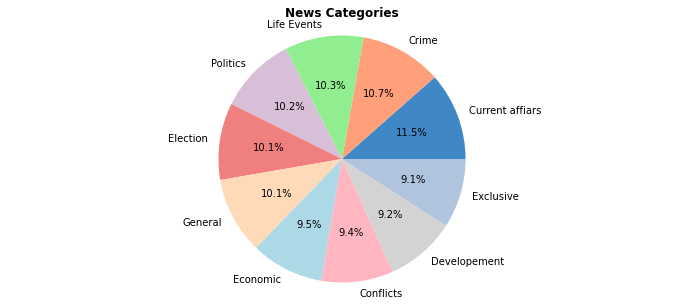

In [20]:
# Create a pie chart using Matplotlib
value_counts = df_topic["News_category"].value_counts()
plt.figure(figsize=(12,5))
colors = ['#3F88C5', '#FFA07A', '#90EE90', '#D8BFD8', '#F08080',
          '#FFDAB9', '#ADD8E6', '#FFB6C1', '#D3D3D3', '#B0C4DE']
plt.pie(value_counts.values, labels=value_counts.index,colors=colors, autopct='%1.1f%%')
plt.title('News Categories', fontweight='bold')
plt.axis('equal')
plt.show()

# Section IV

# **Sentimental Analysis on News Content**

**VADER to find sentiments**

In [22]:
#nltk.download('vader_lexicon') #Its a Lexicon based approach
def analyze_sentiments(df):
    analyzer = SentimentIntensityAnalyzer()
    df_p = df.copy()
    df_p['polarity'] = df_p['content'].apply(lambda x: analyzer.polarity_scores(x))
    df_p = pd.concat([df_p, df_p['polarity'].apply(pd.Series)], axis=1)
    #Apply the rule now and classify
    df_p['sentiment'] = df_p['compound'].apply(lambda x: 'positive' if x > 0 else 'negative')
    return df_p

df_p = analyze_sentiments(df_r)

In [24]:
df_p["sentiment"].value_counts()

positive    88161
negative    54407
Name: sentiment, dtype: int64

# Section V

# **Text Classification Modeling**

**Train test split**

In [26]:
X = df_p['content']
y = df_p['sentiment']


Encoder = LabelEncoder()
y = Encoder.fit_transform(y) #Encoding of Target to 0 and 1

# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=42, stratify=df_p['sentiment'])

**generate TF-IDF to get a matrix**

In [27]:
tf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2)) # Top n Feature on the basis of Tf-Idf value

X_train_tf = tf_vectorizer.fit_transform(X_train)

X_test_tf = tf_vectorizer.transform(X_test)

**Naive Bayes**

In [28]:
naive_bayes_classifier = MultinomialNB() #Model calling
naive_bayes_classifier.fit(X_train_tf, y_train) #Fit to training data

nb_pred_test = naive_bayes_classifier.predict(X_test_tf) #Test data prediction

score1 = metrics.accuracy_score(y_test, nb_pred_test) #Check the accuracy
print("accuracy:   %0.3f" % score1)

accuracy:   0.788


In [29]:
nb_pred_train = naive_bayes_classifier.predict(X_train_tf) #This is train prediction to check

# compute the performance measures
score1 = metrics.accuracy_score(y_train, nb_pred_train) #Check the score
print("accuracy:   %0.3f" % score1)

accuracy:   0.794


**Logistic Regression**

In [30]:
lg_classifier = LogisticRegression() #Call logistic regression model
lg_classifier.fit(X_train_tf, y_train) #Fit the training data

LogisticRegression()

In [31]:
lg_pred_train = lg_classifier.predict(X_train_tf) #Predict the train data
accuracy_train_tfidf = accuracy_score(y_train, lg_pred_train) #Check scoring
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

lg_pred_test = lg_classifier.predict(X_test_tf) #Predict the test data
accuracy_test_tfidf = accuracy_score(y_test, lg_pred_test) #Check how it performs
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))


Accuracy Training data: 92.3%
Accuracy Test data: 90.4%


**Random Forest**

In [32]:
rf_classifier = RandomForestClassifier() #Call Random Forest model
rf_classifier.fit(X_train_tf, y_train) #Fit the training data

RandomForestClassifier()

In [33]:
rf_pred_train = rf_classifier.predict(X_train_tf) #predict training data
accuracy_train_rf = accuracy_score(y_train, rf_pred_train) #Score
print('Accuracy Training data: {:.1%}'.format(accuracy_train_rf))

rf_pred_test = rf_classifier.predict(X_test_tf) #Evaluate test data
accuracy_test_rf = accuracy_score(y_test, rf_pred_test) #Scoring check
#accuracy_test_rf = accuracy_test_rf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_rf))

Accuracy Training data: 100.0%
Accuracy Test data: 81.3%


# Section VI

# **Performance matric**

**Naive Bayes**

**Train**

**Classification report**

In [34]:
print(classification_report(y_train,nb_pred_train))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70     43525
           1       0.80      0.89      0.84     70529

    accuracy                           0.79    114054
   macro avg       0.79      0.76      0.77    114054
weighted avg       0.79      0.79      0.79    114054



**Test**

**Classification report**

In [36]:
print(classification_report(y_test,nb_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     10882
           1       0.79      0.89      0.84     17632

    accuracy                           0.79     28514
   macro avg       0.78      0.76      0.77     28514
weighted avg       0.79      0.79      0.78     28514



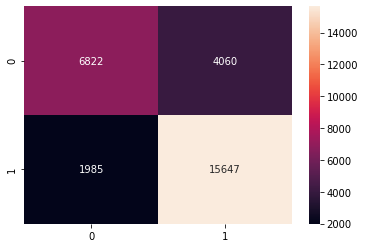

In [37]:
sns.heatmap(confusion_matrix(y_test,nb_pred_test),annot=True,fmt='.5g');

**Logistic regression**

**Train**

In [38]:
print(classification_report(y_train,lg_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90     43525
           1       0.92      0.96      0.94     70529

    accuracy                           0.92    114054
   macro avg       0.93      0.91      0.92    114054
weighted avg       0.92      0.92      0.92    114054



**Test**

In [40]:
print(classification_report(y_test,lg_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87     10882
           1       0.90      0.95      0.92     17632

    accuracy                           0.90     28514
   macro avg       0.91      0.89      0.90     28514
weighted avg       0.90      0.90      0.90     28514



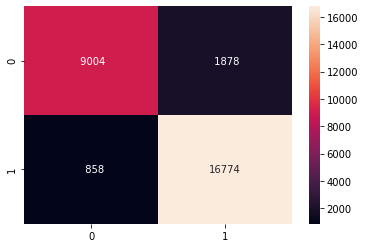

In [41]:
sns.heatmap(confusion_matrix(y_test,lg_pred_test),annot=True,fmt='5g');

**Random Forest**

**Train**

In [42]:
print(classification_report(y_train,rf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43525
           1       1.00      1.00      1.00     70529

    accuracy                           1.00    114054
   macro avg       1.00      1.00      1.00    114054
weighted avg       1.00      1.00      1.00    114054



**Test**

In [44]:
print(classification_report(y_test,rf_pred_test));

              precision    recall  f1-score   support

           0       0.84      0.63      0.72     10882
           1       0.80      0.93      0.86     17632

    accuracy                           0.81     28514
   macro avg       0.82      0.78      0.79     28514
weighted avg       0.82      0.81      0.81     28514



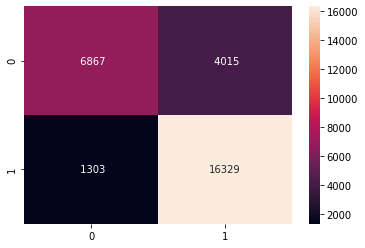

In [45]:
sns.heatmap(confusion_matrix(y_test,rf_pred_test),annot=True,fmt='5g');

**AUC Score Comparisions**

In [46]:
probs=naive_bayes_classifier.predict_proba(X_test_tf)
probs=probs[:,1]
auc_NB_test=roc_auc_score(y_test,probs)
test_fpr_nb,test_tpr_nb,test_thershold_nb=roc_curve(y_test,probs)

probs=lg_classifier.predict_proba(X_test_tf)
probs=probs[:,1]
auc_LG_test=roc_auc_score(y_test,probs)
test_fpr_lg,test_tpr_lg,test_thershold_lg=roc_curve(y_test,probs)

probs=rf_classifier.predict_proba(X_test_tf)
probs=probs[:,1]
auc_RF_test=roc_auc_score(y_test,probs)
test_fpr_rf,test_tpr_rf,test_thershold_rf=roc_curve(y_test,probs)

print("NB",auc_NB_test)
print("LG",auc_LG_test)
print("RF",auc_RF_test)

NB 0.8607221938374731
LG 0.9699192621825748
RF 0.8964189320865206


In [47]:
#All these scores are manually written from above extracted tables and images and manually writen in the report too
test_scores=[0.79,0.90,0.81]
recall_test=[0.89,0.95,0.93]
precision_test=[0.79,0.90,0.80]
f1score_test=[0.84,0.92,0.86]
auc_test=[0.86,0.96,0.89]
performance_comp=(pd.DataFrame({'Test_Accuracy': test_scores,'Test_Recall': recall_test,
                                'Test_precision': precision_test,'Test_f1': f1score_test,'Test_AUC': auc_test},
            index=['Naive Bayes','Logistic Regression','Random Forest']))
cm = sns.light_palette("green", as_cmap=True)
performance_comp.style.background_gradient(cmap=cm).set_precision(2)

,Test_Accuracy,Test_Recall,Test_precision,Test_f1,Test_AUC
Naive Bayes,0.79,0.89,0.79,0.84,0.86
Logistic Regression,0.90,0.95,0.90,0.92,0.96
Random Forest,0.81,0.93,0.80,0.86,0.89


# Section VII

# **Combining Topic and sentiment**

In [48]:
df_p = df_p.reset_index()
df_topic = df_topic.reset_index()
df_combine = pd.concat([df_p,df_topic],axis=1) #Combined sentiment and topic modeling 

In [49]:
df_combine.head(1)

,index,title,content,polarity,neg,neu,pos,compound,sentiment,index,Doc_No,Dominant_Topic,contribution_score,Topic_Word_List,Text,News_category
0,0,house republicans fret winning health care sui...,washington congressional republican fear come ...,"{'neg': 0.148, 'neu': 0.695, 'pos': 0.158, 'co...",0.148,0.695,0.158,0.1803,positive,0,0,7.0,0.3668,"debate, start, win, stop, presidential, exclus...","[house, republicans, fret, winning, health, ca...",Conflicts


In [50]:
df_combine.drop(["index","polarity","neg","neu","pos","compound","Doc_No","Dominant_Topic",
                 "contribution_score","Topic_Word_List","Text"],inplace=True,axis=1)

In [51]:
df_combine.head(1)

,title,content,sentiment,News_category
0,house republicans fret winning health care sui...,washington congressional republican fear come ...,positive,Conflicts


In [52]:
df_combine.groupby(['News_category', 'sentiment']).count() #After deleting all unwanted columns from both, this is final one

title  content
News_category   sentiment                
Conflicts       negative    5262     5262
                positive    8137     8137
Crime           negative    8641     8641
                positive    6627     6627
Current affiars negative    4969     4969
                positive   11430    11430
Developement    negative    4504     4504
                positive    8619     8619
Economic        negative    4457     4457
                positive    9145     9145
Election        negative    5397     5397
                positive    8944     8944
Exclusive       negative    5122     5122
                positive    7813     7813
General         negative    4810     4810
                positive    9530     9530
Life Events     negative    6451     6451
                positive    8222     8222
Politics        negative    4794     4794
                positive    9694     9694